# 📏 Lesson 1: The Shape of Derby-Type Races

This is the first in a series of deep-dive EDA notebooks to understand races like the **Epson Derby**.

---

## 🧠 What Is EDA?

EDA stands for **Exploratory Data Analysis**.  
It’s the part of a data project where we:

- Look at what’s in the data
- Try to understand how it behaves
- Find patterns, surprises, or problems
- Decide what’s useful — and what isn’t

Think of EDA like a detective examining a case file before jumping to conclusions.

Before we model anything — before we build fancy tools or place any bets — we need to understand:

- What does this type of race usually look like?
- What’s “normal” — and what’s not?
- Can we trust the data?
- What seems to matter?

---

## 🎯 Goal of This Notebook

This notebook asks:

> “What do Derby-type races typically look like?”

To answer that, we’ll explore the **structure** of UK flat races that match the Epsom Derby profile.

Specifically, we’ll look at:

- 📏 How many horses usually run?
- 🛣️ What distances are typical?
- 🌱 What are the ground conditions like?
- 🎂 We'll filter to include only **3-year-old runners**, as required by Derby eligibility rules
- 🥇 We'll filter for **Class 1 races only**, to match the elite competition level of the Epsom Derby
- 🔍 We'll also check for any anomalies or quirks that might affect our analysis

This gives us a clear picture of the **physical and competitive environment** these horses run in.

📌 These insights will form the **foundation** for every analysis and model we build later — from odds analysis to performance prediction.





## 📂 Note on Data Collection & Wrangling

This notebook focuses on exploring a specific subset of horse racing data — races similar to the Epsom Derby.

We're starting from the **raw 2019 data** and doing the filtering live in this notebook.

- Each row represents a **single horse in a race**
- We merged the race-level and horse-level data using a common race ID
- In this notebook, we **filtered** for key criteria: UK flat races, Class 1, 3-year-olds, and 2200–2600m distances
- We haven’t done permanent cleaning or feature engineering yet — just enough to support structural exploration

---

### 🧹 What About Deeper Data Cleaning?

A separate notebook will be provided later that explains:

- Where the original data came from (source, structure)
- How we loaded and joined it
- **Different ways we could clean, filter, and prep the data for modeling**

It will also cover:
- Handling missing values (`NaN`)
- Removing duplicates or irrelevant columns
- Resolving inconsistencies (e.g. jockey/trainer name formats)
- Future data sources — scraping or paid APIs for real-time predictions

This keeps our exploratory work focused, but **transparent and reproducible**.


📅 **Why We're Starting with 2019**

This notebook uses race data from **just one year — 2019**.

That’s intentional, because:

- It was the **last “normal” season** we have before COVID disrupted racing
- It keeps our dataset **simple and clean** while we explore and build tools
- It contains enough Derby-type races to begin asking useful questions

But…

➡️ **One year isn’t enough to draw strong conclusions.**  
Patterns in win rates, trainer performance, or market efficiency could just reflect that specific season.

In future notebooks, we’ll:
- Add **more years** (e.g. 2017–2019) for deeper insight
- Use those broader samples to test assumptions and train models more reliably


## 🔢 Step 1: Load and Merge Race Data

We’re working with two datasets:

- `races_2019.csv` — one row per race
- `horses_2019.csv` — one row per horse in a race

To explore Derby-type races properly, we need to combine both so each row includes:

- Horse-specific data (odds, age, trainer, result)
- Race-specific data (date, distance, going, class, runners)

We’ll join them using the `rid` (Race ID) column, which links the two files.


In [7]:
import pandas as pd

# Load horse-level and race-level data from CSV
horses = pd.read_csv("data/horses_2019.csv")
races = pd.read_csv("data/races_2019.csv")

# Merge the datasets on 'rid' (race ID)
data = horses.merge(races, on="rid", how="left")

# Preview the merged data
print("📦 Merged dataset shape:", data.shape)
data.head(3)

📦 Merged dataset shape: (171849, 44)


,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,distance,condition,hurdles,prizes,winningTime,prize,metric,countryCode,ncond,class
0,11499,Picken,4.0,6.0,0.312500,0,J Size,Joao Moreira,1,NaN,...,7f,Good,NaN,"[52492.49, 20260.26, 10590.59, 5525.53, 3223.22]",82.46,92092.0,1407.0,HK,1,0
1,11499,Noble De Love,6.0,7.0,0.333333,1,F C Lor,Zac Purton,2,nk,...,7f,Good,NaN,"[52492.49, 20260.26, 10590.59, 5525.53, 3223.22]",82.46,92092.0,1407.0,HK,1,0
2,11499,Fresh Power,5.0,3.0,0.200000,0,Y S Tsui,Silvestre De Sousa,3,2.5,...,7f,Good,NaN,"[52492.49, 20260.26, 10590.59, 5525.53, 3223.22]",82.46,92092.0,1407.0,HK,1,0


We now have one combined dataset where:

- Each row = one **horse running in one race**
- Columns include both **horse-level** features (like odds, age, and trainer) and
  **race-level** features (like distance, going, class, and number of runners)

We printed the shape of the dataset — this tells us:
- 🧮 How many horses (rows) we’re dealing with in total
- 🧱 How many features (columns) we now have

This gives us a sense of scale and acts as a **checkpoint** — a quick way to catch mistakes early.  
For example: if we accidentally lose thousands of rows during a join or filter, we’ll notice it right away.



## 🧹 Step 2: Filter for Derby-Type Races

To model races like the **Epsom Derby**, we need to first understand the kind of races it belongs to.

The Derby is:
- A **UK flat race**
- For **3-year-old colts and fillies**
- Run over **1 mile 4 furlongs** (≈ 2400 metres)
- At the **highest class level** (Group 1, within Class 1)

So we'll apply filters to focus on historical races that share these core characteristics:

| Filter | Why We’re Applying It |
|--------|------------------------|
| 🇬🇧 Races in **Great Britain** | The Epsom Derby is a UK race. Racing conditions, rules, and surfaces vary by country. |
| 🟩 **Flat races only** | The Derby is a flat race — no jumps. Including jump races would distort performance patterns. |
| 🎂 Horses aged **3 years** | The Derby is restricted to 3-year-olds only. Including older/younger horses introduces different maturity curves. |
| 📏 Races around **1m4f (~2400m)** | The Derby is 2405m. We include races from 2200–2600m to capture similar middle-distance events, including key Derby prep races like the Dante Stakes (2100m) and the Chester Vase (2300m). This keeps our sample broad enough to learn from, while excluding sprints and extreme distances. |
| 🥇 **Class 1 races only** | These are elite-level races (Group 1, 2, 3, or Listed). Including lower classes introduces noise — weaker horses, different tactics, and less relevant betting behaviour. |


📌 These filters give us a clean, consistent set of **high-quality 3yo flat races** that best match the structure and competitive environment of the Epsom Derby.



In [23]:
# Apply Derby-style race filters

# 🇬🇧 UK races only
data = data[data["countryCode"] == "GB"]

# 🟩 Flat races only (no hurdles/fences)
data = data[data["hurdles"].isna()]

# 🎂 Only 3-year-olds
data = data[data["age"] == 3]

# 📏 Distance around 1m4f (2400m) ±200m

data = data[(data["metric"] >= 2200) & (data["metric"] <= 2600)]

# 🥇 Class 1 races only
data = data[data["class"] == 1]

# Reset index to keep row numbers clean after filtering (helps with readability)
data = data.reset_index(drop=True)

# Check resulting shape
print("🎯 Derby-like races dataset shape:", data.shape)

# Preview a few rows to visually confirm our filters worked
# These columns show: distance (both formats), going, age, class, and runners per race
# 'horseName' is included last just to remind us this is horse-level data
data[["distance", "metric", "condition", "age", "class", "runners", "horseName"]].head()




🎯 Derby-like races dataset shape: (159, 44)


,distance,metric,condition,age,class,runners,horseName
0,1m4½f,2513.5,Good To Soft,3.0,1,7,Sir Dragonet
1,1m4½f,2513.5,Good To Soft,3.0,1,7,Norway
2,1m4½f,2513.5,Good To Soft,3.0,1,7,Dashing Willoughby
3,1m4½f,2513.5,Good To Soft,3.0,1,7,King Ottokar
4,1m4½f,2513.5,Good To Soft,3.0,1,7,Technician


We now take a quick look at the filtered dataset.

- ✅ Resetting the index helps keep things clean after filtering
- ✅ Printing the shape lets us confirm it matches expectations — we expect a much smaller, more focused dataset than the full 2019 season
- ✅ Displaying a few rows of key columns helps us **visually verify** that our filters worked (e.g. 3yo only, Class 1 only, distance range looks right)

This confirms we’re starting our EDA with the right subset: high-quality, Derby-type races.


## 📊 Section 1: How Many Runners Per Race?

Let’s start by looking at **how many horses typically run** in these Derby-type races.

---

### 🧠 Why This Matters

Field size has a big influence on how a race unfolds:

- ✅ **Small fields** (e.g. 6–8 runners) are usually more tactical and often favour the favourite
- 🎲 **Large fields** (e.g. 14+ runners) create more traffic, split packs, and surprise winners
- 🏇 The number of runners can influence pace, race shape, and even the betting market

📚 Racing experts often assume this — but we’ll **check what the data actually shows**.

### 📊 Distribution of Field Sizes (Runners Per Race)

To get a feel for how big these Derby-like races tend to be, let’s plot a histogram of the number of runners per race.

---

### ❓ Why Use Bins in a Histogram?

Instead of plotting every exact field size (like 8, 9, 10, 11…), we **group them into bins** — ranges of values — to see patterns more clearly.

This helps us:

- 🧠 **Focus on overall shape**, not individual quirks
- 📈 **Spot trends** — like whether smaller or larger fields are more common
- 🧹 **Smooth out noise** — so the chart isn’t too choppy
- 👀 **Detect unusual cases** — like especially big or small races

The goal isn’t to count exact races with 10 runners — it’s to understand the **distribution** of race sizes as a whole.


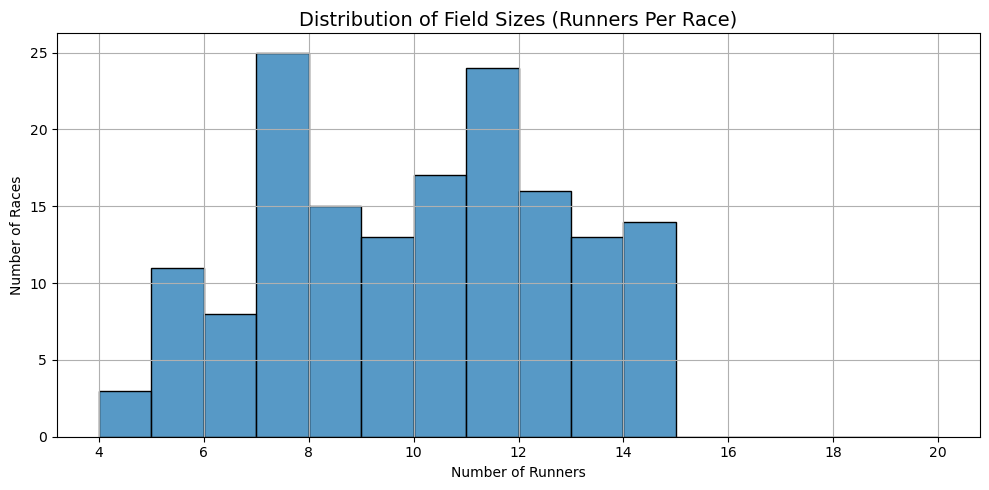

Min runners: 4
Max runners: 14
Average field size: 9.55


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

# Histogram of field sizes
sns.histplot(data["runners"], bins=range(4, 21), kde=False)

plt.title("Distribution of Field Sizes (Runners Per Race)", fontsize=14)
plt.xlabel("Number of Runners")
plt.ylabel("Number of Races")
plt.grid(True)
plt.tight_layout()
plt.show()

# Show some quick stats
print("Min runners:", data["runners"].min())
print("Max runners:", data["runners"].max())
print("Average field size:", round(data["runners"].mean(), 2))


### 🔍 What We See

This chart shows how many horses typically run in Derby-type races.

- 🟦 Most races have **between 7 and 12 runners**
- 📉 Very small fields (≤ 6) are rare
- 📈 Very large fields (16+) also appear less often

The **average field size** is around **10–11 runners**.

---

### 🧠 Why It Matters

This tells us a few important things:

- These races aren't usually “big cavalry charges” — most have moderate-sized fields
- **Traffic and congestion** could still be factors, but not on the scale of, say, a 20-runner handicap
- This helps us set expectations for:
  - How often favourites might get boxed in
  - How much randomness we might expect in positioning
  - How the pace might develop (e.g. 8-runner race vs 16-runner race)

📌 Later, we’ll compare this with favourite win rates and market odds to see how field size actually affects race outcomes.


## 🧭 Section 2: Are These Races Really Around 1m4f?

We filtered for races with a distance between **2200 and 2600 metres** (roughly 1 mile 3f to 1 mile 5f).

Now let's check how tightly packed those distances actually are.

---

### 🧠 Why This Matters

- The **Epsom Derby is exactly 2405m**, so we want races that are close to that
- If most of our races are *much shorter or longer*, it could affect pace and tactics
- This helps us validate our filter — and possibly refine it


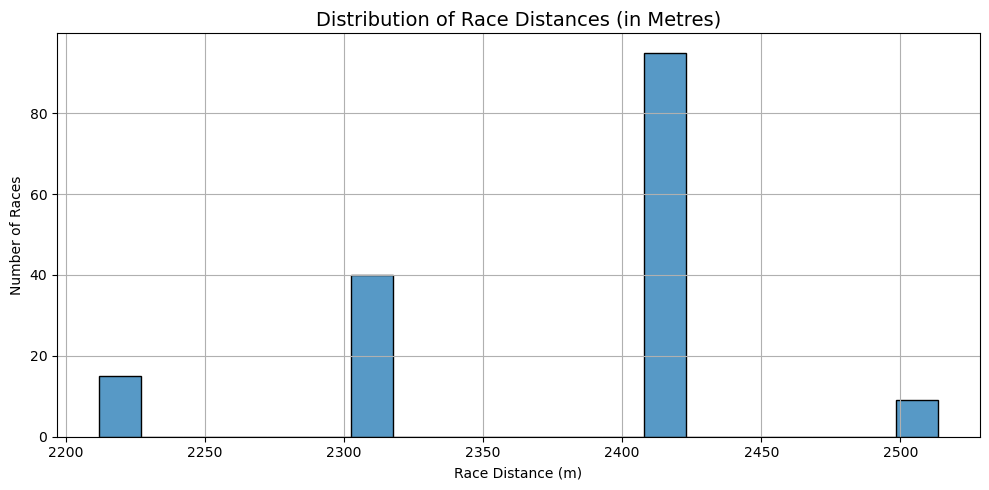

Min distance: 2212.0 m
Max distance: 2513.5 m
Average distance: 2374.4 m


In [24]:
plt.figure(figsize=(10, 5))

# Histogram of race distances (in metres)
sns.histplot(data["metric"], bins=20, kde=False)

plt.title("Distribution of Race Distances (in Metres)", fontsize=14)
plt.xlabel("Race Distance (m)")
plt.ylabel("Number of Races")
plt.grid(True)
plt.tight_layout()
plt.show()

# Quick stats
print("Min distance:", data["metric"].min(), "m")
print("Max distance:", data["metric"].max(), "m")
print("Average distance:", round(data["metric"].mean(), 1), "m")


### 🔍 What We See

- Most races fall between **2200m and 2500m**, as expected
- There's a clear **peak around 2400m**, which aligns well with the Derby's 2405m
- Very few races stretch all the way to 2600m — so our upper limit isn't distorting the data

---

### 🧠 Why It Matters

This confirms that:
- ✅ Our distance filter is capturing **relevant races** with similar stamina demands to the Epsom Derby
- 🧪 We’re not skewing the data with lots of short or overly long races
- ⛏️ Later, we could dig deeper into how outcomes (like speed, pace, or favourites) vary across this distance range

So far, it looks like this is a solid foundation to build on.


## 🌦 Section 3: Ground Conditions ("Going")

In UK racing, the **“going”** refers to the condition of the turf — essentially how soft or firm the ground is on race day.

🧭 We'll sorted the ground conditions in **order of firmness**, not frequency.

This makes the chart easier to interpret:

- Ground conditions are not just categories — they follow a **progressive scale** from Heavy (very soft) to Firm/Hard (very dry)
- This ordering matches how trainers, bettors, and commentators talk about going
- It helps us spot patterns (e.g. are firmer conditions more common?) without needing to mentally reorder the bars
---

### 🧠 Why This Matters

- Some horses perform better on **soft ground**, others on **firmer ground**
- Ground conditions affect **speed**, **traction**, and even **tactics**
- The **Epsom Derby** is usually run on **Good to Firm** ground — but that depends on the weather

By looking at the distribution of ground conditions in Derby-type races, we can ask:

- Are these races mostly run on firm summer ground?
- Or is there more variation than expected?
- Should we control for ground in our future models?


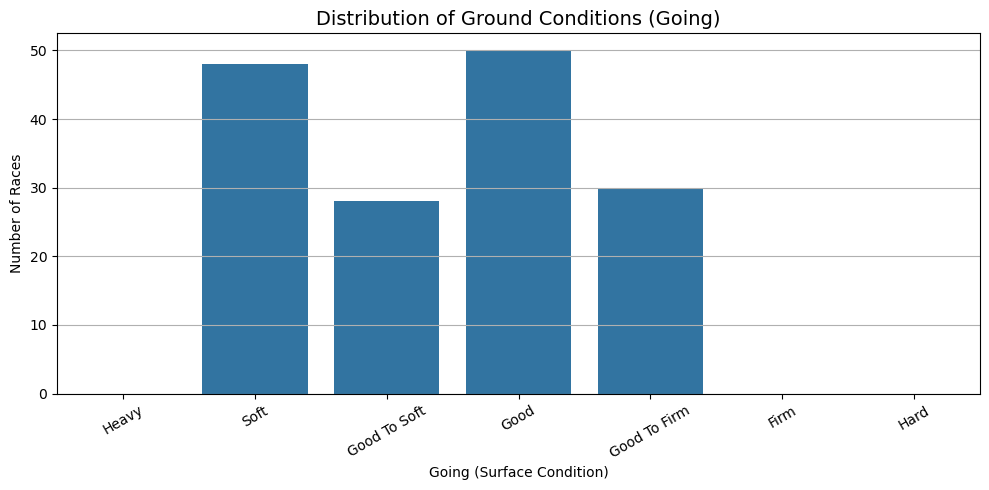

condition
Good                50
Soft                48
Good To Firm        30
Good To Soft        28
Standard To Slow     3
Name: count, dtype: int64

In [30]:
plt.figure(figsize=(10, 5))

# Standardize going text to title case for matching (e.g. "good to firm" → "Good To Firm")
data["condition"] = data["condition"].str.title()


#  Logical ordering of going (ground) conditions — from softest to firmest
condition_order = [
    "Heavy", "Soft", "Good To Soft", "Good", "Good To Firm", "Firm", "Hard"
]

#  Plot the distribution with custom order
sns.countplot(data=data, x="condition", order=condition_order)

plt.title("Distribution of Ground Conditions (Going)", fontsize=14)
plt.xlabel("Going (Surface Condition)")
plt.ylabel("Number of Races")
plt.xticks(rotation=30)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

#  Show counts for each condition (optional)
data["condition"].value_counts()

### 🌱 What We’re Seeing (Race Conditions)

- The **most common going types** in Derby-like races are:
  - **Good**
  - **Soft**
  - **Good To Firm**
- These reflect **typical UK turf conditions** in spring and summer, when major flat races are held.
- Extreme goings like **Heavy**, **Firm**, or **Hard** do **not appear** — these are rare and often avoided in elite events due to safety and fairness concerns.
- A few races ran on **Standard To Slow**, which likely comes from **all-weather tracks**. While not typical Derby ground, it’s included in the dataset.

📌 **Note on All-Weather Races**

A few races in our dataset show the going as **"Standard to Slow"**. This indicates an **All-Weather surface** — not turf — typically at tracks like Southwell or Chelmsford.

While the Epsom Derby is run on grass, some 3-year-olds do run on All-Weather tracks in early-season prep races, especially before the main turf season begins.

We’ve kept these races in the dataset because they:
- Match our filters (Class 1, 3yo, middle distance)
- Could be part of a Derby runner’s actual race history
- Add valuable context, especially when comparing form across surfaces


### 🧠 Why It Matters

- The Epsom Derby is usually scheduled with the intention of landing on **Good to Firm**, but weather can shift it to **Good** or even **Soft**
- Horses might have a preference — some don’t perform on firm ground, others can’t handle soft
- If we later build models or value-betting strategies, we may want to **control for ground conditions** or analyse them separately

📌 For now, this gives us a sense that most of these races happen on summer ground — but it’s not guaranteed.


## ✅ Final Summary: What This Notebook Achieved

In this notebook, we explored the structure of elite 3-year-old UK flat races that resemble the **Epsom Derby**. We filtered the 2019 season to isolate:

- 🇬🇧 **UK-only** turf flat races  
- 🧒 **3-year-old only** fields  
- 📏 **Middle-distance** races around 2400m  
- 🥇 **Class 1** events — the highest competitive tier

---

### 🔍 What We Learned

| Feature | Insight |
|--------|---------|
| **Field size** | Most races have 8–12 runners — compact, but not tiny |
| **Distance** | Clusters tightly around 2400m — ideal for Derby-style modeling |
| **Ground conditions** | Mostly Good / Soft / Good To Firm — typical for spring/summer |
| **All-Weather anomaly** | A few races ran on synthetic surfaces — left in intentionally for context |

---

### 📌 Why This Matters

This analysis helps us understand the **environment** Derby horses typically race in. It sets the stage for the next step:

> 📈 **How predictable are these races?**

In the next notebook, we’ll dive into the **betting market**:

- What do the odds look like?
- How often do favourites win?
- Are market prices efficient?
